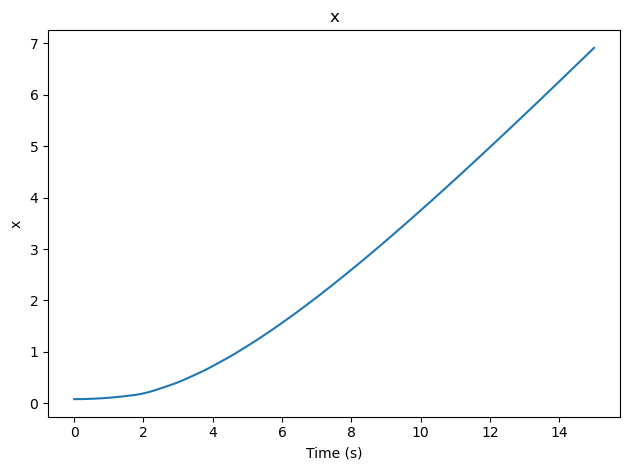

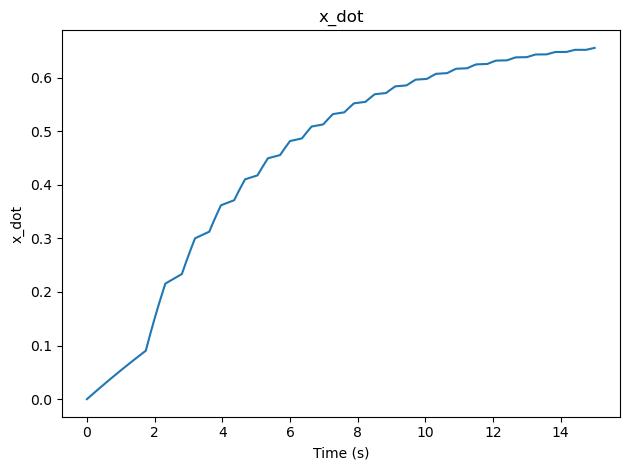

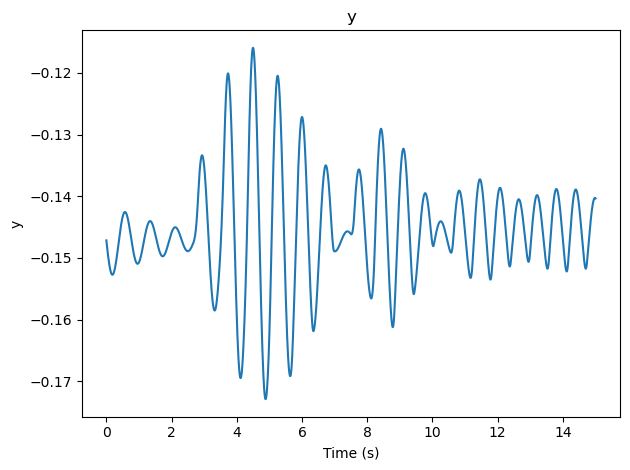

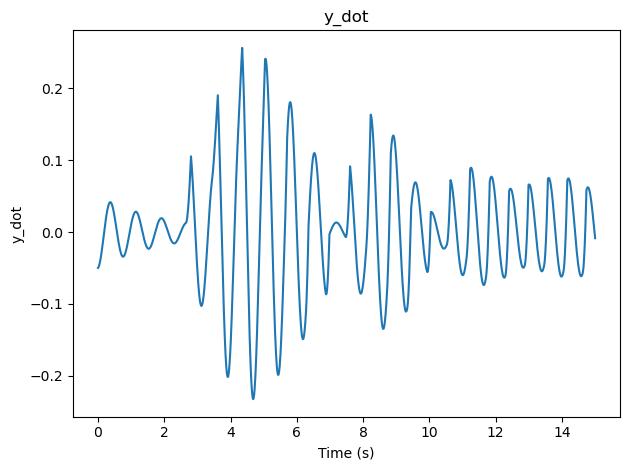

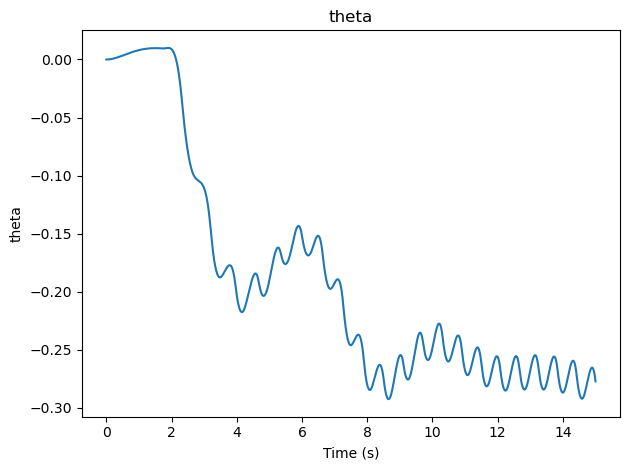

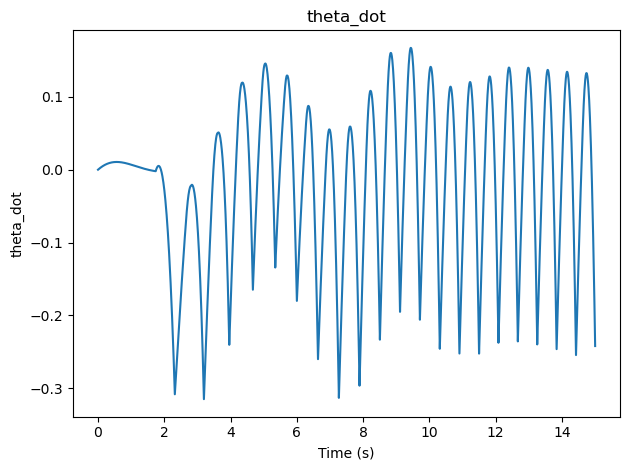

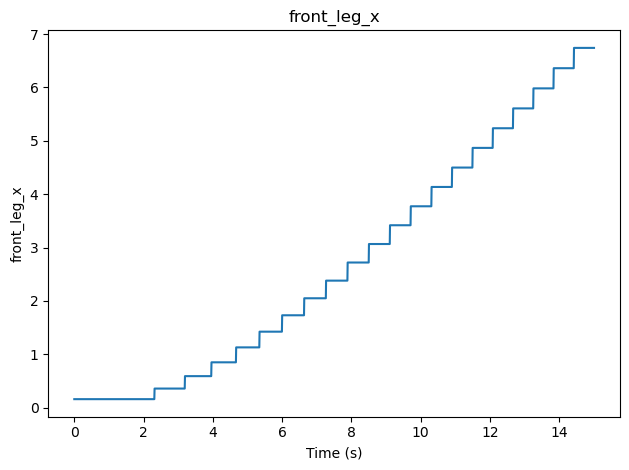

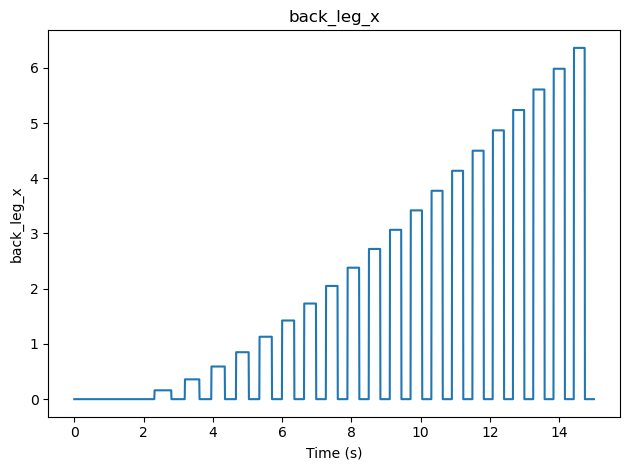

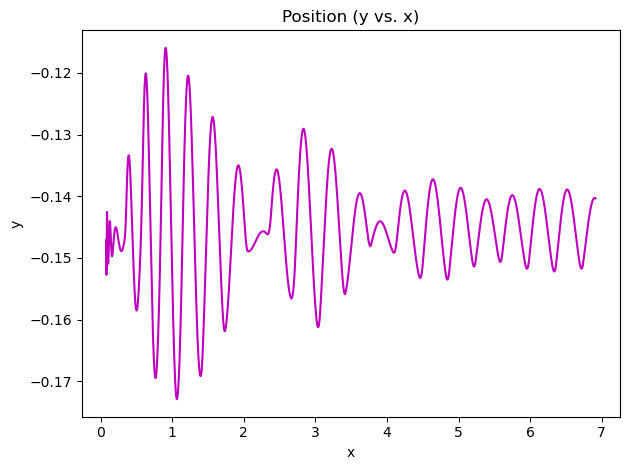

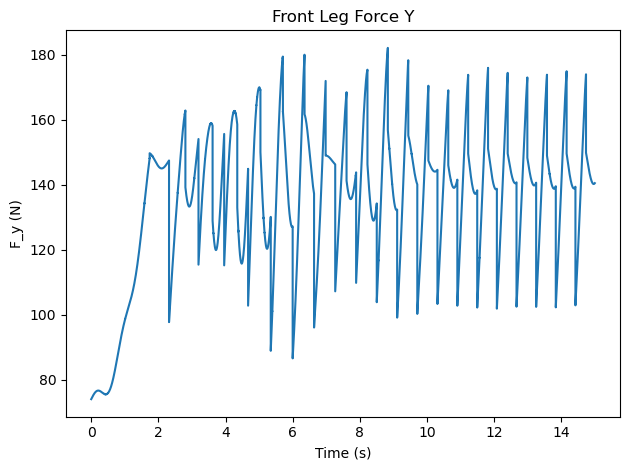

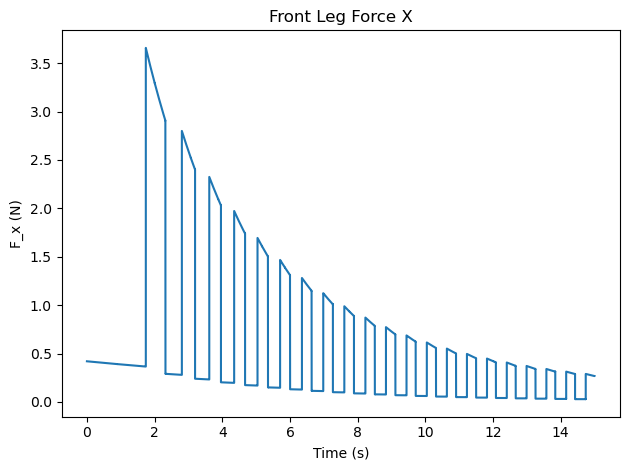

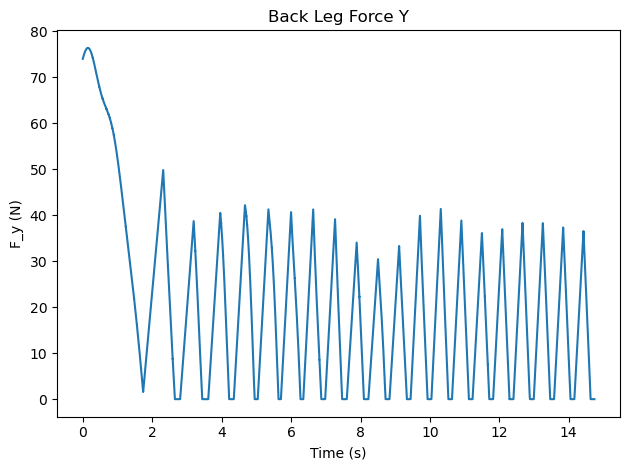

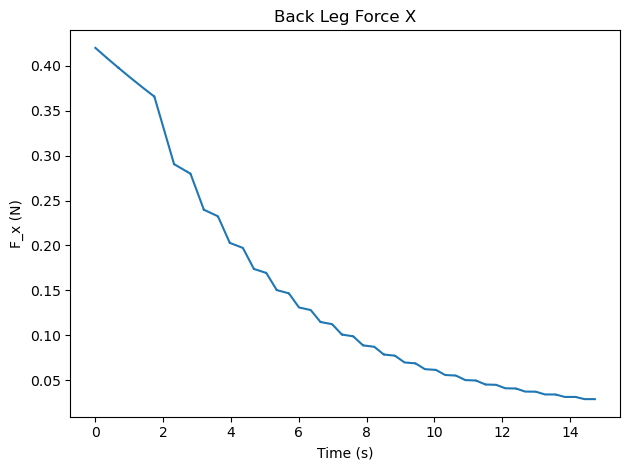

Animation saved as: granny_animation.gif
Done!


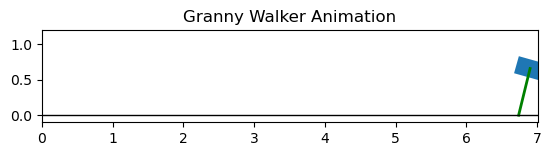

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import imageio
from math import sin, cos

# Parameters
m = 15.0 
k = 1000.0      
b = 15.0        
I = m*(0.75**2) 
b_v = 0.1       

# Desired velocity and gain for virtual model
x_dotdes = 0.7  # m/s
k_v = 1.2       # gain

# Initial distance for front/back legs
d = 0.08

# Initial state: [x, x_dot, y, y_dot, theta, theta_dot, front_leg_x, back_leg_x]
q_init = np.array([
    d, 
    0.0, 
    -9.81*m/k, 
    -0.05, 
    0.0, 
    0.0, 
    2.0*d,  # front_leg_x
    0.0     # back_leg_x
])

# For logging states after each time step
q_print = [q_init.copy()]
front_legF = []
back_legF  = []

# Simulation parameters
tspan = (0.0, 15.0)
dt = 0.0075
current_time = 0.0

def doubleStance(t, q):

    fy_des   = -k*q[2] - b*q[3]
    tau_des  = -(k/25.0)*q[4] - b*q[5]
    
    # Distance from COM to leg contacts
    l1 = q[6] - q[0]           # front leg
    l2 = abs(q[7] - q[0])      # back leg

    # Solve for front and back vertical forces so that total torque is tau_des
    f_fronty = (tau_des + fy_des*l2) / (l1 + l2)
    if f_fronty < 0.0:
        f_fronty = 0.0
    f_backy = fy_des - f_fronty
    if f_backy < 0.0:
        f_backy = 0.0

    f_frontx = (k_v*(x_dotdes - q[1]))**1/2.0
    f_backx  = f_frontx

    # Log forces at this instant
    front_legF.append([t, f_frontx, f_fronty])
    back_legF.append([t,  f_backx,  f_backy])

    dqdt = np.zeros_like(q)
    dqdt[0] = q[1]
    dqdt[1] = (f_frontx + f_backx - b_v*q[1]) / m
    dqdt[2] = q[3]
    dqdt[3] = (f_fronty + f_backy - m*9.81) / m
    dqdt[4] = q[5]
    dqdt[5] = (f_fronty*l1 - f_backy*l2 + f_frontx*0.4 + f_backx*0.4) / I
    dqdt[6] = 0.0
    dqdt[7] = 0.0

    return dqdt

def singleStance(t, q):
    # Vertical force
    fy_des   = -k*q[2] - b*q[3]
    f_fronty = fy_des
    if f_fronty < 0.0:
        f_fronty = 0.0

    f_frontx = 5.0*(k_v*(x_dotdes - q[1]))
    # Log front leg forces
    front_legF.append([t, f_frontx, f_fronty])
    l2 = abs(q[6] - q[0])

    dqdt = np.zeros_like(q)
    dqdt[0] = q[1]
    dqdt[1] = (f_frontx - b_v*q[1]) / m
    dqdt[2] = q[3]
    dqdt[3] = (f_fronty - m*9.81) / m
    dqdt[4] = q[5]
    dqdt[5] = (-f_fronty*l2 + f_frontx*0.4) / I
    dqdt[6] = 0.0
    dqdt[7] = 0.0

    return dqdt

# Time stepping
times = [current_time]
while current_time < tspan[1]:
    # Update step distance
    q_cur = q_print[-1]
    d_dynamic = q_cur[1]/x_dotdes * 0.13 + 0.05

    # Leg switch logic
    if q_cur[6] <= (q_cur[0] - d_dynamic):
        # move the back leg to the old front leg
        q_cur[7] = q_cur[6]
        # move the front leg forward
        q_cur[6] = q_cur[0] + 1.2*d_dynamic

    if q_cur[0] <= q_cur[6]:
        # Double Stance
        sol = solve_ivp(doubleStance, [current_time, current_time+dt], q_cur, 
                        t_eval=[current_time+dt])
        next_state = sol.y[:, -1]
    else:
        # Single Stance
        q_cur[7] = 0.0
        sol = solve_ivp(singleStance, [current_time, current_time+dt], q_cur,
                        t_eval=[current_time+dt])
        next_state = sol.y[:, -1]

    # Update for next iteration
    q_print.append(next_state)
    current_time += dt
    times.append(current_time)

q_print = np.array(q_print)
times = np.array(times)

#Plotting
state_labels = ["x", "x_dot", "y", "y_dot", "theta", "theta_dot", 
                "front_leg_x", "back_leg_x"]

for i in range(8):
    plt.figure()
    plt.plot(times, q_print[:, i], '-')
    plt.title(state_labels[i])
    plt.xlabel("Time (s)")
    plt.ylabel(state_labels[i])
    plt.tight_layout()
    plt.show()

# Plot y vs x
plt.figure()
plt.plot(q_print[:, 0], q_print[:, 2], '-m')
plt.title("Position (y vs. x)")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()

front_legF = np.array(front_legF)  # shape: (N, 3) => [time, Fx, Fy]
back_legF  = np.array(back_legF)   # shape: (M, 3)

if len(front_legF) > 0:
    # Front Leg Force Y
    plt.figure()
    plt.plot(front_legF[:,0], front_legF[:,2], '-')
    plt.title("Front Leg Force Y")
    plt.xlabel("Time (s)")
    plt.ylabel("F_y (N)")
    plt.tight_layout()
    plt.show()

    # Front Leg Force X
    plt.figure()
    plt.plot(front_legF[:,0], front_legF[:,1], '-')
    plt.title("Front Leg Force X")
    plt.xlabel("Time (s)")
    plt.ylabel("F_x (N)")
    plt.tight_layout()
    plt.show()

if len(back_legF) > 0:
    # Back Leg Force Y
    plt.figure()
    plt.plot(back_legF[:,0], back_legF[:,2], '-')
    plt.title("Back Leg Force Y")
    plt.xlabel("Time (s)")
    plt.ylabel("F_y (N)")
    plt.tight_layout()
    plt.show()

    # Back Leg Force X
    plt.figure()
    plt.plot(back_legF[:,0], back_legF[:,1], '-')
    plt.title("Back Leg Force X")
    plt.xlabel("Time (s)")
    plt.ylabel("F_x (N)")
    plt.tight_layout()
    plt.show()

#Animation
filename = "granny_animation.gif"
frames = []
frame_delay = 0.04

fig, ax = plt.subplots()
ax.set_aspect("equal", "box")
ax.set_xlim([0, max(q_print[:,0]) + 0.1])
ax.set_ylim([-0.1, 1.2])
plt.title("Granny Walker Animation")

# The corners of the rectangle, in local coords:
width  = 0.4
height = 0.25
half_w = 0.5 * width
half_h = 0.5 * height

body_box  = plt.Polygon([[0,0],[0,0],[0,0],[0,0]], closed=True)
leg_line1, = ax.plot([], [], 'g-', lw=2)  # front leg
leg_line2, = ax.plot([], [], 'b-', lw=2)  # back leg
ground_line, = ax.plot([0, max(q_print[:,0]) + 0.1],[0,0],'k-',lw=1)

ax.add_patch(body_box)

# Animation loop (taking every Nth point for speed)
step = 9
for i in range(0, len(q_print), step):
    x     = q_print[i, 0]
    y     = q_print[i, 2]
    theta = q_print[i, 4]
    fl_x  = q_print[i, 6]
    bl_x  = q_print[i, 7]

    # Rotation matrix
    R = np.array([[ cos(theta), -sin(theta)],
                  [ sin(theta),  cos(theta)]])

    # corners of the rectangle in local coords
    corners_local = np.array([
        [-half_w, -half_h],
        [ half_w, -half_h],
        [ half_w,  half_h],
        [-half_w,  half_h]
    ])
    # rotate + translate
    corners_global = (R @ corners_local.T).T
    corners_global[:,0] += x
    corners_global[:,1] += (y + 0.8)  # body offset above the ground

    body_box.set_xy(corners_global)

    # front leg
    if fl_x > 0:
        leg_line1.set_xdata([x, fl_x])
        leg_line1.set_ydata([y+0.8, 0])
    else:
        # if for some reason fl_x <= 0, we can just keep it “folded”
        leg_line1.set_xdata([x, x])
        leg_line1.set_ydata([y+0.8, y+0.8])

    # back leg
    if bl_x > 0:
        leg_line2.set_xdata([x, bl_x])
        leg_line2.set_ydata([y+0.8, 0])
    else:
        leg_line2.set_xdata([x, x])
        leg_line2.set_ydata([y+0.8, y+0.8])

    # Grab this frame from the figure
    fig.canvas.draw()
    frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    frames.append(frame.copy())

# Save as animated GIF via imageio
with imageio.get_writer(filename, mode='I', duration=frame_delay) as writer:
    for f in frames:
        writer.append_data(f)

print("Animation saved as:", filename)
print("Done!")
